In [1]:
import jax
import jax.numpy as jnp

from flax import linen as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wandb
from wandb.apis.public import Api

import time
from dataclasses import dataclass

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Setup

In [2]:
# Configuration
PROJECT_NAME = "induced_metric"
RUN_INDEX = 4  # Change this to analyze different run indices
ENTITY_NAME = "thomas_harvey"  # Change this to your WandB entity name

# Speedrun target perplexity values (lower is better for perplexity)
SPEEDRUN_TARGETS = [12.0, 10.0, 8.0, 6.0, 5.0, 4.6, 4.5, 4.4, 4.0, 3.5]

# Optimizer names to analyze
OPTIMISERS = ['adam', 'adamw', 'sgd', 'sgd_metric', 'sgd_log_metric', 'muon', 'sgd_rms']

print(f"Analyzing run index: {RUN_INDEX}")
print(f"Project: {PROJECT_NAME}")
print(f"Optimisers: {OPTIMISERS}")
print(f"Speedrun targets (perplexity): {SPEEDRUN_TARGETS}")
print(f"Note: Analyzing BEST result from 3 best configurations (Phase 2) for each optimizer")

api = Api()

Analyzing run index: 4
Project: induced_metric
Optimisers: ['adam', 'adamw', 'sgd', 'sgd_metric', 'sgd_log_metric', 'muon', 'sgd_rms']
Speedrun targets (perplexity): [12.0, 10.0, 8.0, 6.0, 5.0, 4.6, 4.5, 4.4, 4.0, 3.5]
Note: Analyzing BEST result from 3 best configurations (Phase 2) for each optimizer


# Prepare Data

In [3]:
# Get the best run for each optimizer directly using API sorting
best_runs = {}
best_50_runs = {}

for optimizer in OPTIMISERS:
    print(f"Finding best run for {optimizer}...")

    # Get runs sorted by final_min_val_perplexity (ascending = best first, since lower perplexity is better)
    optimizer_runs = api.runs(
        PROJECT_NAME, 
        filters={
            "$and": [
                {"tags": "shakespeare_minigpt"}, 
                {"tags": f"run_{RUN_INDEX}"}, 
                {"tags": optimizer}
            ]
        },
        order="+summary_metrics.final_min_val_perplexity"
    )
    
    # Take the first run (best one)
    if len(optimizer_runs) > 0:
        best_run = optimizer_runs[0]
        best_50_runs[optimizer] = optimizer_runs[:50]
        best_final_min_val_perplexity = best_run.summary.get('final_min_val_perplexity', None)

        if best_final_min_val_perplexity is not None:
            best_runs[optimizer] = best_run
            print(f"{optimizer}: {best_run.name} (final_min_val_perplexity: {best_final_min_val_perplexity:.4f})")
        else:
            print(f"{optimizer}: No valid final_min_val_perplexity found in best run")
    else:
        print(f"{optimizer}: No runs found")

print(f"\nFound best runs for {len(best_runs)} optimizers")

Finding best run for adam...
adam: rich-sweep-57 (final_min_val_perplexity: 4.3259)
Finding best run for adamw...
adamw: driven-sweep-410 (final_min_val_perplexity: 4.3066)
Finding best run for sgd...
sgd: dulcet-sweep-15 (final_min_val_perplexity: 5.0447)
Finding best run for sgd_metric...
sgd_metric: grateful-sweep-405 (final_min_val_perplexity: 7.0647)
Finding best run for sgd_log_metric...
sgd_log_metric: ethereal-sweep-278 (final_min_val_perplexity: 7.6232)
Finding best run for muon...
muon: ancient-sweep-337 (final_min_val_perplexity: 4.3559)
Finding best run for sgd_rms...
sgd_rms: tough-sweep-487 (final_min_val_perplexity: 4.3613)

Found best runs for 7 optimizers


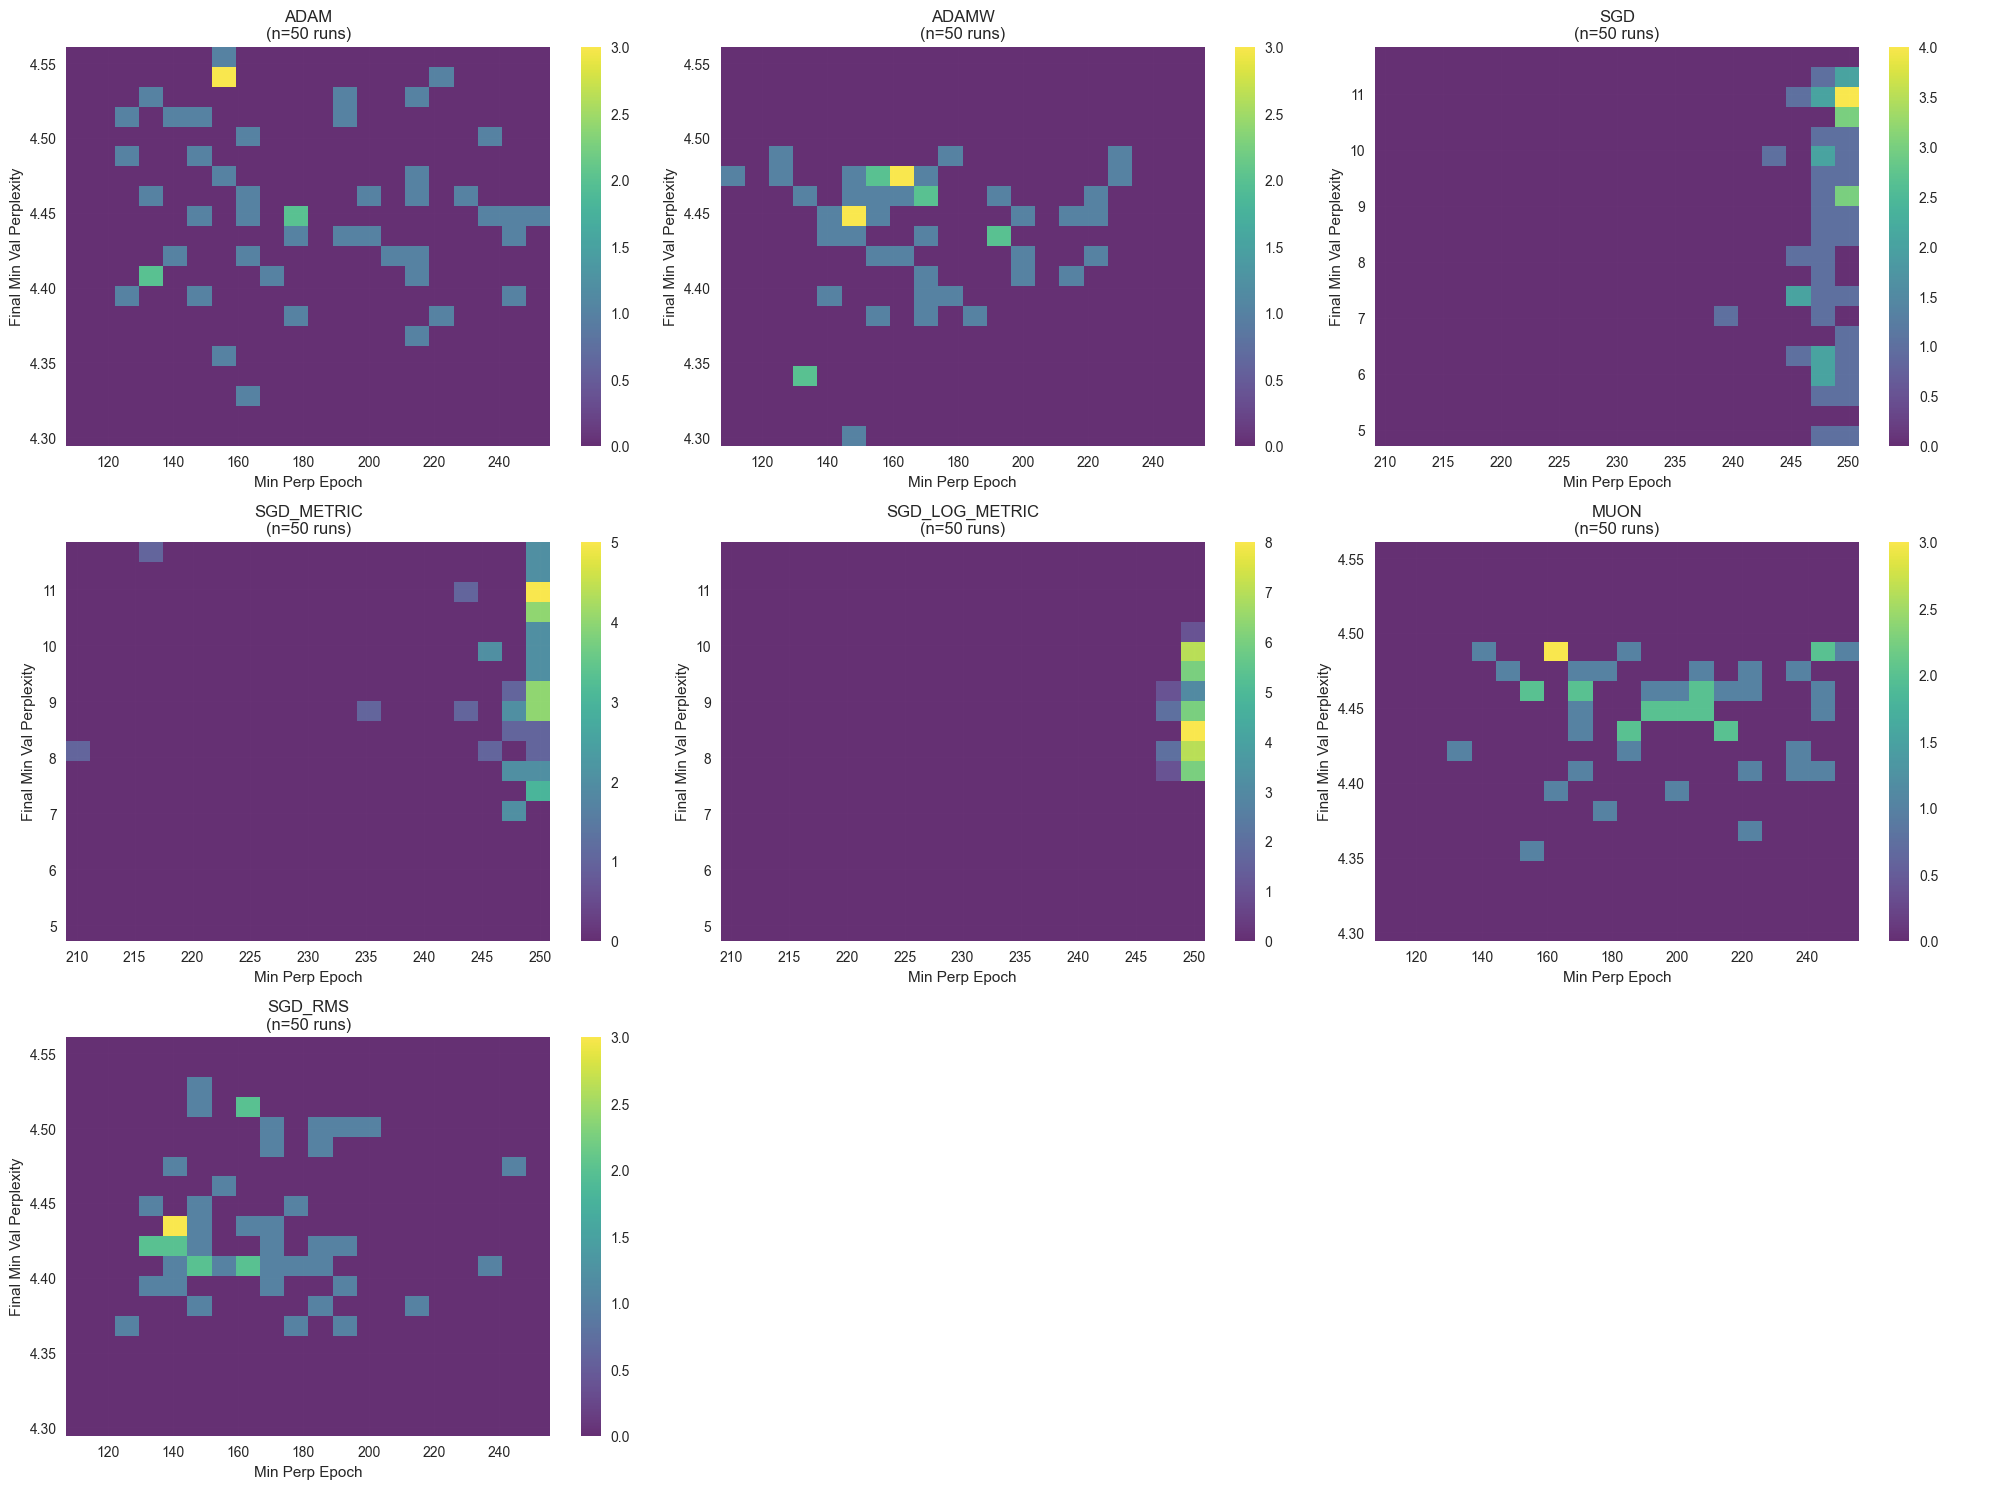

Summary Statistics: Min Val Perplexity vs Min Perp Epoch

ADAM:
  Runs with data: 50
  Min Val Perplexity - Mean: 4.455187, Std: 0.053800
  Min Perp Epoch - Mean: 180.5, Std: 37.1
  Best Min Val Perplexity: 4.325860 at epoch 165

ADAMW:
  Runs with data: 50
  Min Val Perplexity - Mean: 4.437223, Std: 0.039655
  Min Perp Epoch - Mean: 168.7, Std: 28.8
  Best Min Val Perplexity: 4.306597 at epoch 151

SGD:
  Runs with data: 50
  Min Val Perplexity - Mean: 8.643028, Std: 1.925947
  Min Perp Epoch - Mean: 247.9, Std: 1.6
  Best Min Val Perplexity: 5.044700 at epoch 248

SGD_METRIC:
  Runs with data: 50
  Min Val Perplexity - Mean: 9.364901, Std: 1.311992
  Min Perp Epoch - Mean: 246.7, Std: 7.2
  Best Min Val Perplexity: 7.064726 at epoch 248

SGD_LOG_METRIC:
  Runs with data: 50
  Min Val Perplexity - Mean: 8.797687, Std: 0.753113
  Min Perp Epoch - Mean: 248.8, Std: 0.5
  Best Min Val Perplexity: 7.623210 at epoch 249

MUON:
  Runs with data: 50
  Min Val Perplexity - Mean: 4.446662, Std

In [16]:
# Create 2D histograms for each optimizer showing final_min_val_perplexity vs final_min_perp_epoch
# with normalized axes for easier comparison
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

# Define optimizer groups
group1_optimizers = ['adam', 'adamw', 'muon', 'sgd_rms']
group2_optimizers = ['sgd', 'sgd_metric', 'sgd_log_metric']

# Function to calculate ranges and bins for a group of optimizers
def get_group_ranges_and_bins(optimizer_group):
    all_min_val_perplexities = []
    all_min_perp_epochs = []

    for optimizer in optimizer_group:
        if optimizer in best_50_runs:
            for run in best_50_runs[optimizer]:
                min_val_perplexity = run.summary.get('final_min_val_perplexity', None)
                min_perp_epoch = run.summary.get('final_min_perp_epoch', None)
                
                if min_val_perplexity is not None and min_perp_epoch is not None:
                    all_min_val_perplexities.append(min_val_perplexity)
                    all_min_perp_epochs.append(min_perp_epoch)

    if not all_min_val_perplexities:
        return None, None, None, None, None, None

    perp_min = min(all_min_val_perplexities)
    perp_max = max(all_min_val_perplexities)
    epoch_min = min(all_min_perp_epochs)
    epoch_max = max(all_min_perp_epochs)
    
    perp_range = perp_max - perp_min
    epoch_range = epoch_max - epoch_min
    
    perp_bins = np.linspace(perp_min - perp_range * 0.05, perp_max + perp_range * 0.05, 21)
    epoch_bins = np.linspace(epoch_min - epoch_range * 0.05, epoch_max + epoch_range * 0.05, 21)
    
    return (perp_min, perp_max), (epoch_min, epoch_max), perp_bins, epoch_bins, perp_range, epoch_range

# Get ranges and bins for each group
group1_perp_limits, group1_epoch_limits, group1_perp_bins, group1_epoch_bins, group1_perp_range, group1_epoch_range = get_group_ranges_and_bins(group1_optimizers)
group2_perp_limits, group2_epoch_limits, group2_perp_bins, group2_epoch_bins, group2_perp_range, group2_epoch_range = get_group_ranges_and_bins(group2_optimizers)


# Second pass: create histograms with consistent bins per group
for i, optimizer in enumerate(OPTIMISERS):
    if optimizer in best_50_runs:
        # Collect data from the best 50 runs
        min_val_perplexities = []
        min_perp_epochs = []
        
        for run in best_50_runs[optimizer]:
            min_val_perplexity = run.summary.get('final_min_val_perplexity', None)
            min_perp_epoch = run.summary.get('final_min_perp_epoch', None)
            
            if min_val_perplexity is not None and min_perp_epoch is not None:
                min_val_perplexities.append(min_val_perplexity)
                min_perp_epochs.append(min_perp_epoch)
        
        if len(min_val_perplexities) > 0:
            # Determine which group the optimizer belongs to
            if optimizer in group1_optimizers and group1_epoch_bins is not None:
                epoch_bins, perp_bins = group1_epoch_bins, group1_perp_bins
                epoch_limits, perp_limits = group1_epoch_limits, group1_perp_limits
                epoch_range, perp_range = group1_epoch_range, group1_perp_range
            elif optimizer in group2_optimizers and group2_epoch_bins is not None:
                epoch_bins, perp_bins = group2_epoch_bins, group2_perp_bins
                epoch_limits, perp_limits = group2_epoch_limits, group2_perp_limits
                epoch_range, perp_range = group2_epoch_range, group2_perp_range
            else:
                # Fallback for optimizers not in any group or if group has no data
                axes[i].text(0.5, 0.5, f'No data for {optimizer}', 
                             ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{optimizer.upper()}\n(No data)')
                continue

            # Create 2D histogram with consistent bins for the group
            h = axes[i].hist2d(min_perp_epochs, min_val_perplexities, 
                              bins=[epoch_bins, perp_bins], 
                              cmap='viridis', alpha=0.8)
            
            # Add colorbar
            plt.colorbar(h[3], ax=axes[i])
            
            # Set title and labels
            axes[i].set_title(f'{optimizer.upper()}\n(n={len(min_val_perplexities)} runs)')
            axes[i].set_xlabel('Min Perp Epoch')
            axes[i].set_ylabel('Final Min Val Perplexity')
            axes[i].grid(True, alpha=0.3)
            
            # Set consistent axis limits for the group
            axes[i].set_xlim(epoch_limits[0] - epoch_range * 0.05, epoch_limits[1] + epoch_range * 0.05)
            axes[i].set_ylim(perp_limits[0] - perp_range * 0.05, perp_limits[1] + perp_range * 0.05)
        else:
            axes[i].text(0.5, 0.5, f'No data for {optimizer}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{optimizer.upper()}\n(No data)')

# Hide any unused subplots
for j in range(len(OPTIMISERS), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Create a summary statistics table
print("Summary Statistics: Min Val Perplexity vs Min Perp Epoch")
print("=" * 80)

for optimizer in OPTIMISERS:
    if optimizer in best_50_runs:
        min_val_perplexities = []
        min_perp_epochs = []

        for run in best_50_runs[optimizer]:
            min_val_perplexity = run.summary.get('final_min_val_perplexity', None)
            min_perp_epoch = run.summary.get('final_min_perp_epoch', None)
            
            if min_val_perplexity is not None and min_perp_epoch is not None:
                min_val_perplexities.append(min_val_perplexity)
                min_perp_epochs.append(min_perp_epoch)
        
        if len(min_val_perplexities) > 0:
            print(f"\n{optimizer.upper()}:")
            print(f"  Runs with data: {len(min_val_perplexities)}")
            print(f"  Min Val Perplexity - Mean: {np.mean(min_val_perplexities):.6f}, Std: {np.std(min_val_perplexities):.6f}")
            print(f"  Min Perp Epoch - Mean: {np.mean(min_perp_epochs):.1f}, Std: {np.std(min_perp_epochs):.1f}")
            print(f"  Best Min Val Perplexity: {np.min(min_val_perplexities):.6f} at epoch {min_perp_epochs[np.argmin(min_val_perplexities)]}")


In [5]:
# Collect data for all optimizers
optimizer_data = {}

for optimizer, run in best_runs.items():
    print(f"Processing {optimizer}...")
    
    # Get history data
    history = run.scan_history()
    
    # Collect data
    epochs = []
    train_losses = []
    val_perplexities = []
    runtimes = []
    
    for row in history:
        if 'epoch' in row and row['epoch'] is not None:
            epochs.append(row['epoch'])
            train_losses.append(row.get('train_loss', None))
            val_perplexities.append(row.get('val_perplexity', None))
            runtimes.append(row.get('train_time_seconds', None))
    
    # Convert runtime to cumulative wall time
    if runtimes and runtimes[0] is not None:
        runtimes = [-rt+runtimes[0] for rt in runtimes if rt is not None]
        start_time = runtimes[0] if runtimes else 0
        wall_times = [rt - start_time for rt in runtimes]
    else:
        wall_times = list(range(len(epochs)))  # Fallback to epoch numbers
    
    # Sample every 5th epoch plus the last epoch
    sample_count = 1
    valid_indices = list(range(0, len(epochs), sample_count))
    if len(epochs) - 1 not in valid_indices:
        valid_indices.append(len(epochs) - 1)
    
    # Filter data
    epochs_filtered = np.array([epochs[i] for i in valid_indices])
    train_losses_filtered = np.array([train_losses[i] for i in valid_indices if train_losses[i] is not None])
    val_perplexities_filtered = np.array([val_perplexities[i] for i in valid_indices if val_perplexities[i] is not None])
    wall_times_filtered = np.array([wall_times[i] for i in valid_indices if i < len(wall_times)])
    
    # Ensure all arrays have the same length
    min_length = min(len(epochs_filtered), len(train_losses_filtered), len(val_perplexities_filtered), len(wall_times_filtered))
    
    optimizer_data[optimizer] = {
        'epochs': epochs_filtered[:min_length],
        'train_losses': train_losses_filtered[:min_length],
        'val_perplexities': val_perplexities_filtered[:min_length],
        'wall_times': wall_times_filtered[:min_length]
    }

print(f"\nProcessed data for {len(optimizer_data)} optimizers")

Processing adam...
Processing adamw...
Processing sgd...
Processing sgd_metric...
Processing sgd_log_metric...
Processing muon...
Processing sgd_rms...

Processed data for 7 optimizers


Time to reach best perplexity for each optimizer's best run:
ADAM           :     8.18s at epoch 165 (val_perp: 4.325860)
ADAMW          :     6.84s at epoch 151 (val_perp: 4.306597)
SGD            :     8.76s at epoch 248 (val_perp: 5.044700)
SGD_METRIC     :     8.26s at epoch 248 (val_perp: 7.064726)
SGD_LOG_METRIC :     8.65s at epoch 249 (val_perp: 7.623210)
MUON           :    41.01s at epoch 155 (val_perp: 4.355860)
SGD_RMS        :     8.02s at epoch 177 (val_perp: 4.361292)


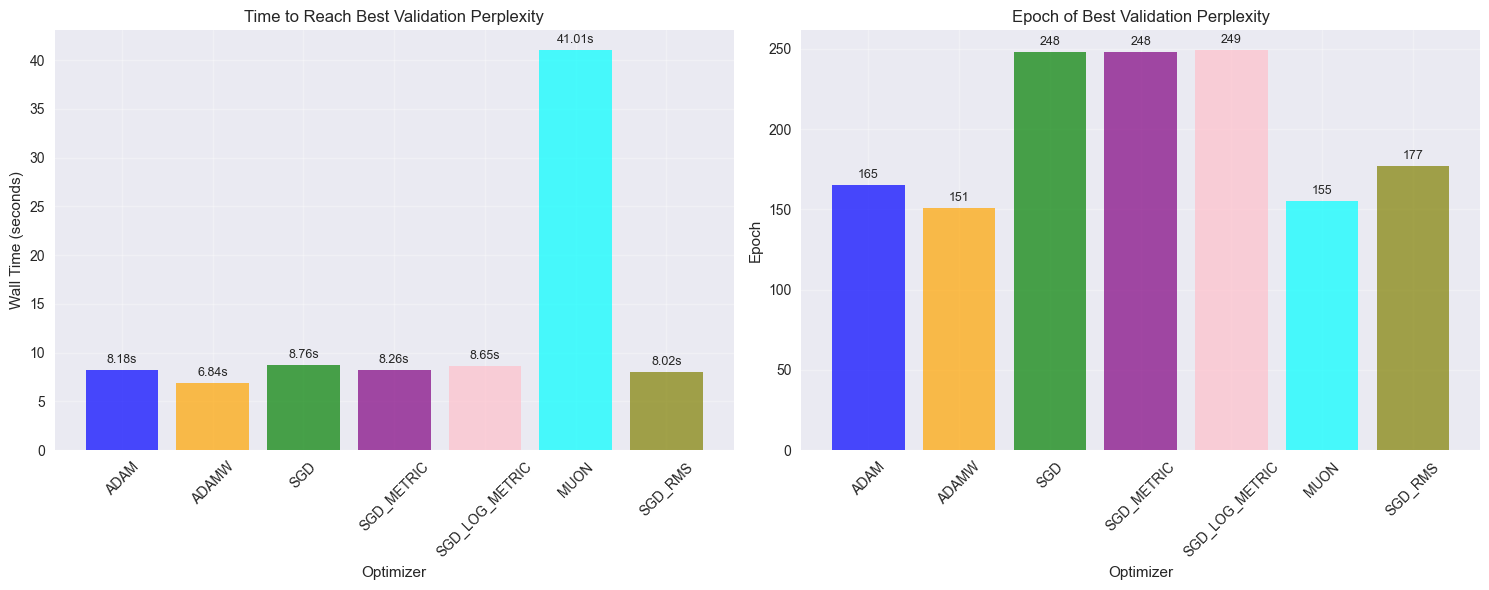


Summary Statistics:
Fastest to best perplexity: ADAMW (6.84s)
Slowest to best perplexity: MUON (41.01s)
Earliest epoch: ADAMW (epoch 151)
Latest epoch: SGD_LOG_METRIC (epoch 249)


In [6]:
optimizer_colors = {
    'sgd_rms': 'olive',
    'adam': 'blue',
    'adamw': 'orange',
    'sgd': 'green',
    'sgd_metric': 'purple',
    'sgd_log_metric': 'pink',
    'muon': 'cyan'
}

# Extract time to reach best perplexity for each optimizer's best run
best_times = {}

print("Time to reach best perplexity for each optimizer's best run:")
print("=" * 70)

for optimizer in OPTIMISERS:
    if optimizer in best_runs and optimizer in optimizer_data:
        # Get the final_min_perp_epoch from the best run summary
        best_run = best_runs[optimizer]
        min_perp_epoch = best_run.summary.get('final_min_perp_epoch', None)

        if min_perp_epoch is not None:
            # Find the corresponding wall time from optimizer_data
            data = optimizer_data[optimizer]

            # Find the index where epoch equals min_perp_epoch
            epoch_indices = np.where(data['epochs'] == min_perp_epoch)[0]
            
            if len(epoch_indices) > 0:
                epoch_idx = epoch_indices[0]
                wall_time_to_best = data['wall_times'][epoch_idx]
                val_perp_best = data['val_perplexities'][epoch_idx]

                best_times[optimizer] = {
                    'epoch': min_perp_epoch,
                    'wall_time': wall_time_to_best,
                    'val_perp': val_perp_best
                }

                print(f"{optimizer.upper():<15}: {wall_time_to_best:>8.2f}s at epoch {min_perp_epoch:>3d} (val_perp: {val_perp_best:.6f})")
            else:
                print(f"{optimizer.upper():<15}: Epoch {min_perp_epoch} not found in data")
        else:
            print(f"{optimizer.upper():<15}: No final_min_perp_epoch found")

# Create a comparison plot
if best_times:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    optimizers_list = list(best_times.keys())
    wall_times_list = [best_times[opt]['wall_time'] for opt in optimizers_list]
    epochs_list = [best_times[opt]['epoch'] for opt in optimizers_list]
    colors_list = [optimizer_colors[opt] for opt in optimizers_list]
    
    # Plot wall times
    bars1 = ax1.bar(range(len(optimizers_list)), wall_times_list, color=colors_list, alpha=0.7)
    ax1.set_xlabel('Optimizer')
    ax1.set_ylabel('Wall Time (seconds)')
    ax1.set_title('Time to Reach Best Validation Perplexity')
    ax1.set_xticks(range(len(optimizers_list)))
    ax1.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    # Plot epochs
    bars2 = ax2.bar(range(len(optimizers_list)), epochs_list, color=colors_list, alpha=0.7)
    ax2.set_xlabel('Optimizer')
    ax2.set_ylabel('Epoch')
    ax2.set_title('Epoch of Best Validation Perplexity')
    ax2.set_xticks(range(len(optimizers_list)))
    ax2.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nSummary Statistics:")
    print(f"Fastest to best perplexity: {min(best_times.items(), key=lambda x: x[1]['wall_time'])[0].upper()} ({min(wall_times_list):.2f}s)")
    print(f"Slowest to best perplexity: {max(best_times.items(), key=lambda x: x[1]['wall_time'])[0].upper()} ({max(wall_times_list):.2f}s)")
    print(f"Earliest epoch: {min(best_times.items(), key=lambda x: x[1]['epoch'])[0].upper()} (epoch {min(epochs_list)})")
    print(f"Latest epoch: {max(best_times.items(), key=lambda x: x[1]['epoch'])[0].upper()} (epoch {max(epochs_list)})")

# Train Loss and Validation Perplexity Curves

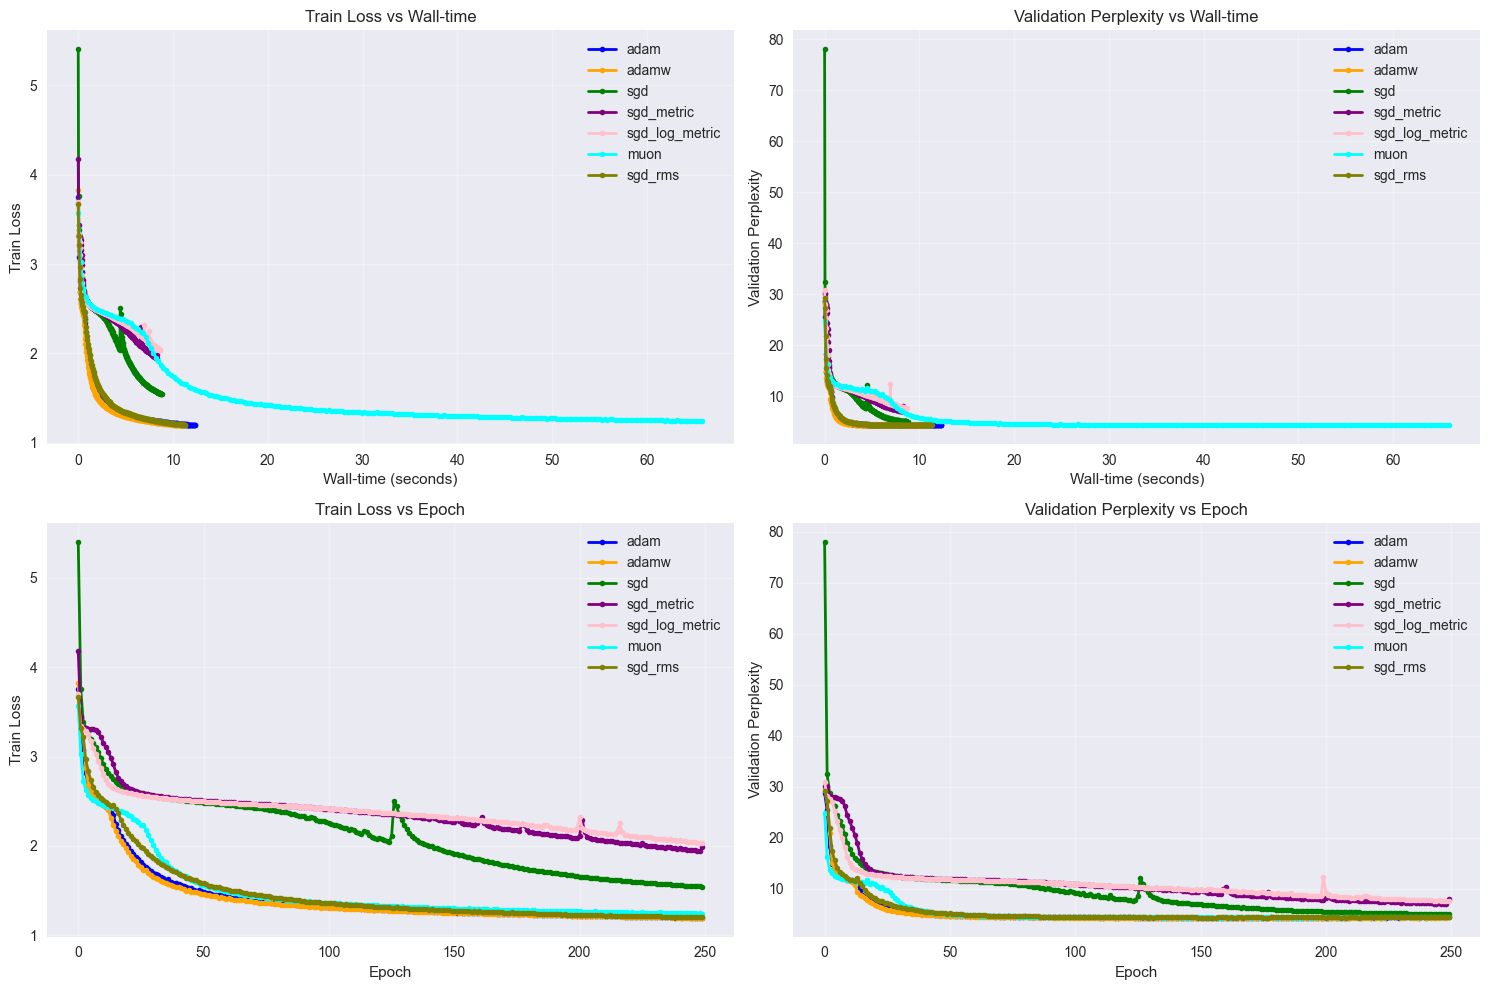

In [7]:
optimizer_colors = {
    'sgd_rms': 'olive',
    'adam': 'blue',
    'adamw': 'orange',
    'sgd': 'green',
    'sgd_metric': 'purple',
    'sgd_log_metric': 'pink',
    'muon': 'cyan'
}

# Create subplots for all optimizers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for optimizer, data in optimizer_data.items():
    color = optimizer_colors[optimizer]
    
    # Plot Train Loss vs Wall-time
    axes[0, 0].plot(data['wall_times'], data['train_losses'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Validation Perplexity vs Wall-time
    axes[0, 1].plot(data['wall_times'], data['val_perplexities'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Train Loss vs Epoch
    axes[1, 0].plot(data['epochs'], data['train_losses'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Validation Perplexity vs Epoch
    axes[1, 1].plot(data['epochs'], data['val_perplexities'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)

# Set titles and labels
axes[0, 0].set_title('Train Loss vs Wall-time')
axes[0, 0].set_xlabel('Wall-time (seconds)')
axes[0, 0].set_ylabel('Train Loss')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].set_title('Validation Perplexity vs Wall-time')
axes[0, 1].set_xlabel('Wall-time (seconds)')
axes[0, 1].set_ylabel('Validation Perplexity')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].set_title('Train Loss vs Epoch')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Train Loss')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].set_title('Validation Perplexity vs Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Perplexity')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

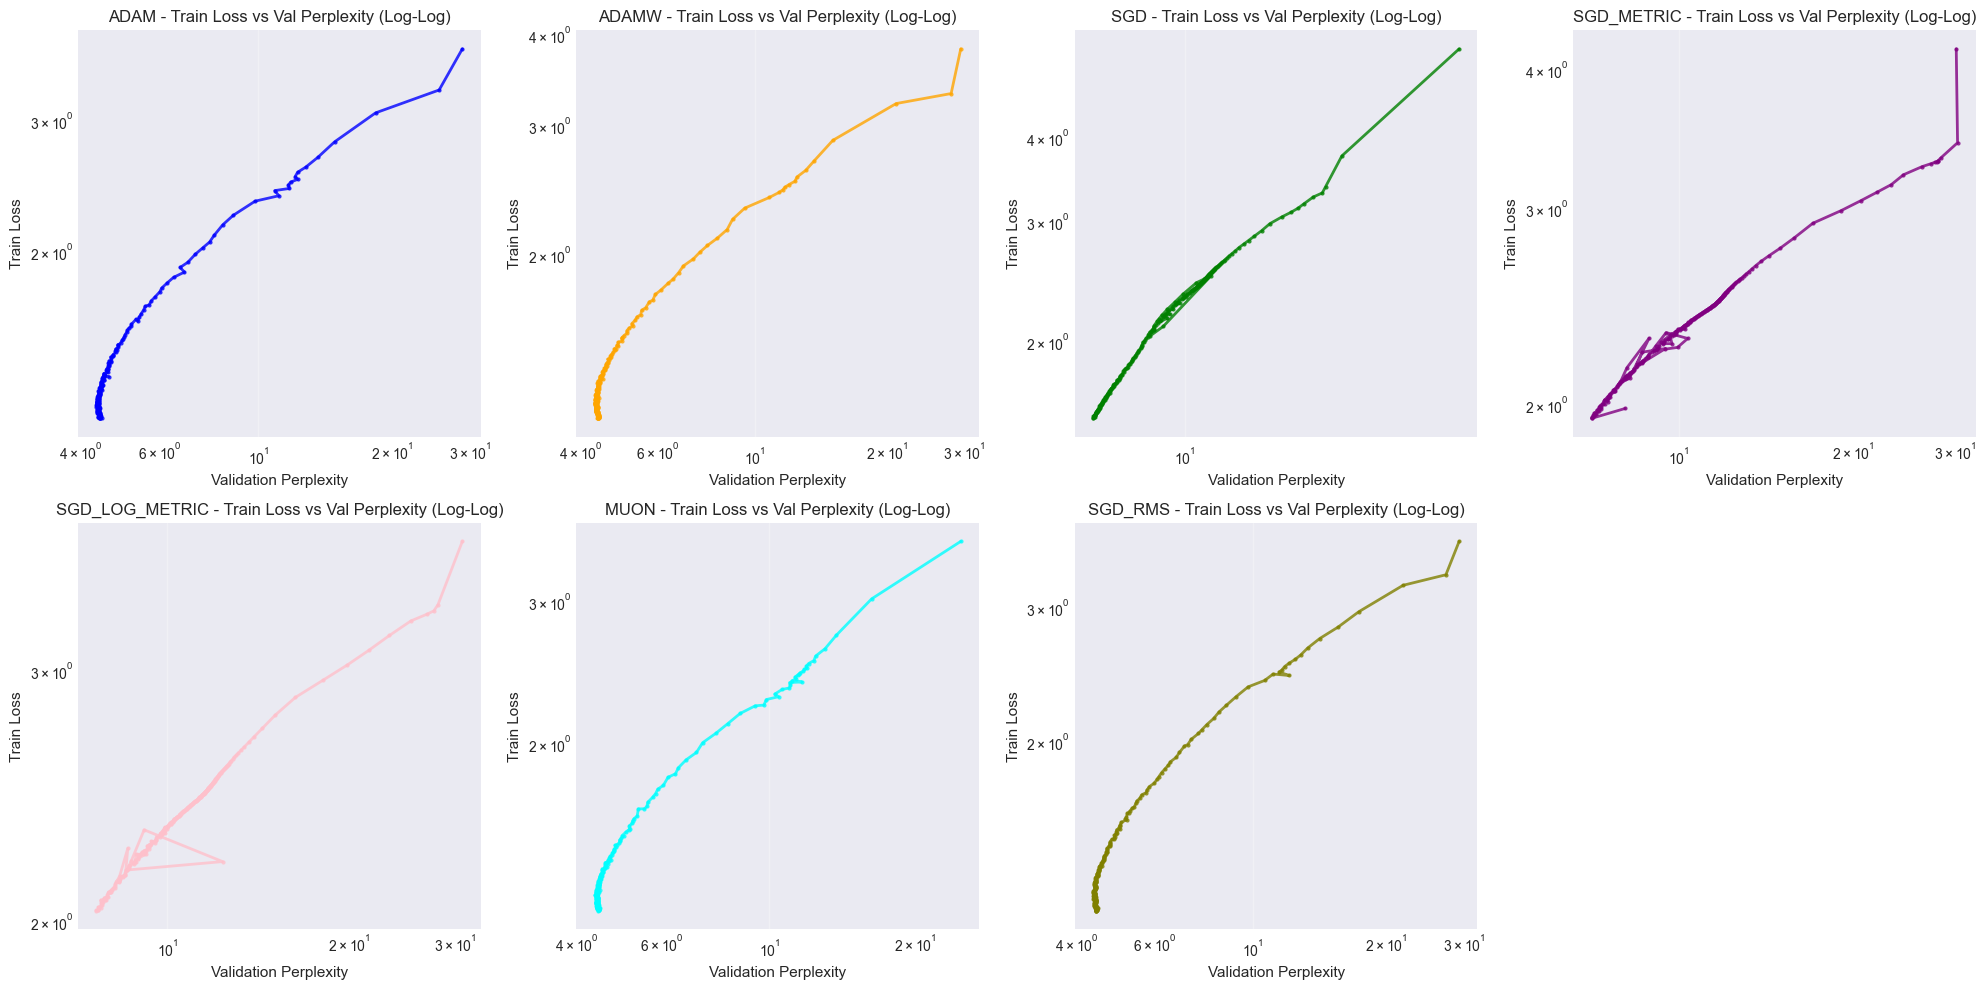

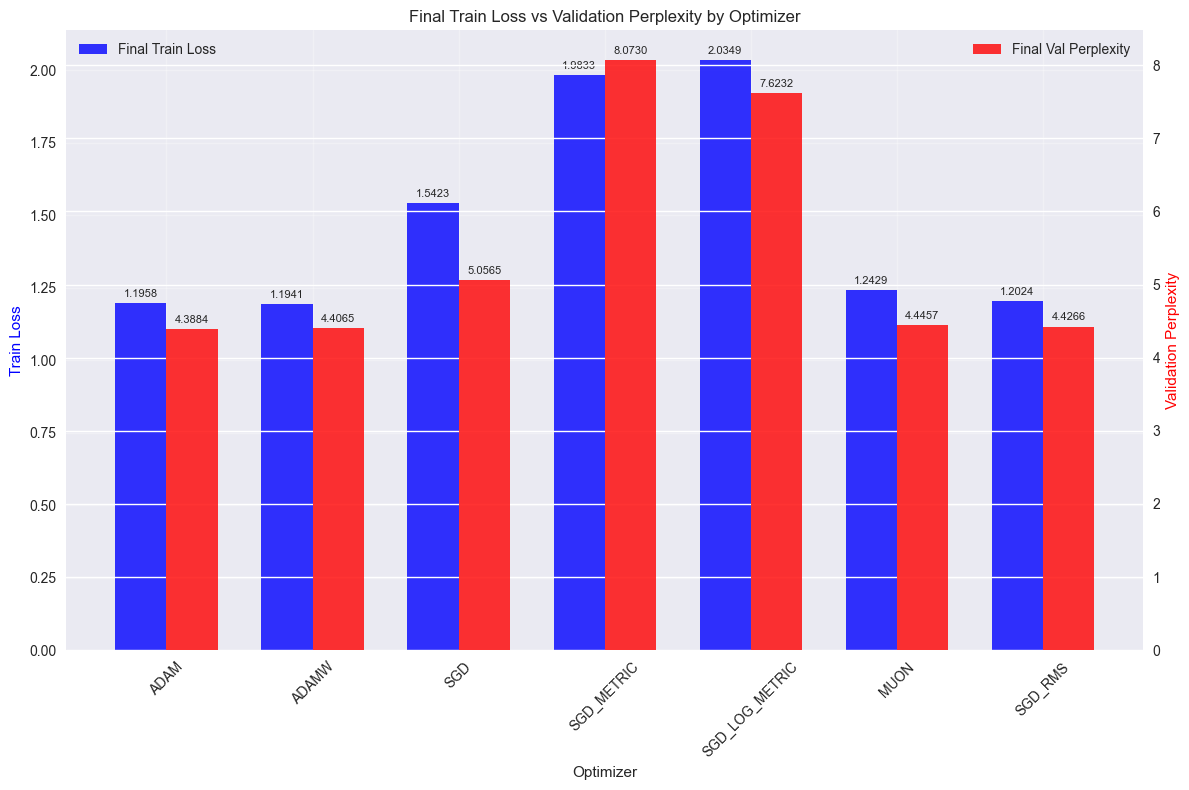

In [8]:
# Create individual plots for each optimizer showing training vs validation performance on log-log scale
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Changed to 2x4 to accommodate 7 optimizers
axes = axes.flatten()

for i, (optimizer, data) in enumerate(optimizer_data.items()):
    color = optimizer_colors[optimizer]
    
    # Plot validation perplexity (x-axis) vs train loss (y-axis) on log-log scale
    valid_mask = (data['train_losses'] > 0) & (data['val_perplexities'] > 0)
    train_losses_filtered = data['train_losses'][valid_mask]
    val_perplexities_filtered = data['val_perplexities'][valid_mask]
    
    # Plot validation perplexity vs train loss on log-log scale
    axes[i].loglog(val_perplexities_filtered, train_losses_filtered, 'o-', 
                   linewidth=2, markersize=3, color=color, alpha=0.8)
    
    # Set title and labels
    axes[i].set_title(f'{optimizer.upper()} - Train Loss vs Val Perplexity (Log-Log)')
    axes[i].set_xlabel('Validation Perplexity')
    axes[i].set_ylabel('Train Loss')
    axes[i].grid(True, alpha=0.3)

# Hide the 8th subplot since we only have 7 optimizers
axes[7].set_visible(False)

plt.tight_layout()
plt.show()

# Create a summary plot comparing final metrics
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

optimizers_list = list(optimizer_data.keys())
train_final = [optimizer_data[opt]['train_losses'][-1] for opt in optimizers_list]
val_perp_final = [optimizer_data[opt]['val_perplexities'][-1] for opt in optimizers_list]

x_pos = np.arange(len(optimizers_list))
width = 0.35

# Create a secondary y-axis for perplexity
ax2 = ax.twinx()

bars1 = ax.bar(x_pos - width/2, train_final, width, label='Final Train Loss', alpha=0.8, color='blue')
bars2 = ax2.bar(x_pos + width/2, val_perp_final, width, label='Final Val Perplexity', alpha=0.8, color='red')

ax.set_xlabel('Optimizer')
ax.set_ylabel('Train Loss', color='blue')
ax2.set_ylabel('Validation Perplexity', color='red')
ax.set_title('Final Train Loss vs Validation Perplexity by Optimizer')
ax.set_xticks(x_pos)
ax.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
ax.grid(True, alpha=0.3)

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Speedtests

In [9]:
# Calculate speedrun times for each target
speedrun_results = {}

for optimizer, data in optimizer_data.items():
    speedrun_results[optimizer] = {}
    
    for target in SPEEDRUN_TARGETS:
        # Find the first epoch where validation perplexity goes below the target (lower is better)
        below_target_indices = np.where(data['val_perplexities'] <= target)[0]
        
        if len(below_target_indices) > 0:
            first_index = below_target_indices[0]
            speedrun_results[optimizer][target] = {
                'epoch': data['epochs'][first_index],
                'wall_time': data['wall_times'][first_index],
                'val_perplexity': data['val_perplexities'][first_index]
            }
        else:
            speedrun_results[optimizer][target] = {
                'epoch': None,
                'wall_time': None,
                'val_perplexity': None
            }

# Create a summary table
print("Speedrun Results: Time to reach target validation perplexity")
print("=" * 80)

# Create header
header = f"{'Optimizer':<15}"
for target in SPEEDRUN_TARGETS:
    header += f"{target:<8}"
print(header)
print("-" * 80)

# Print results for each optimizer
for optimizer in OPTIMISERS:
    if optimizer in speedrun_results:
        row = f"{optimizer:<15}"
        for target in SPEEDRUN_TARGETS:
            result = speedrun_results[optimizer][target]
            if result['wall_time'] is not None:
                row += f"{result['wall_time']:<8.1f}"
            else:
                row += f"{'--':<8}"
        print(row)

print("\nNote: Times shown are wall-clock seconds to first achieve target validation perplexity")
print("'--' indicates the target was never reached during training")

# Create a more detailed table with epochs
print("\n\nDetailed Speedrun Results")
print("=" * 100)

for target in SPEEDRUN_TARGETS[:5]:  # Show first 5 targets for detail
    print(f"\nTarget Validation Perplexity: {target}")
    print(f"{'Optimizer':<15} {'Epoch':<8} {'Wall Time (s)':<15} {'Actual Perp':<12}")
    print("-" * 50)
    
    for optimizer in OPTIMISERS:
        if optimizer in speedrun_results:
            result = speedrun_results[optimizer][target]
            if result['epoch'] is not None:
                print(f"{optimizer:<15} {result['epoch']:<8} {result['wall_time']:<15.2f} {result['val_perplexity']:<12.6f}")
            else:
                print(f"{optimizer:<15} {'--':<8} {'--':<15} {'--':<12}")

Speedrun Results: Time to reach target validation perplexity
Optimizer      12.0    10.0    8.0     6.0     5.0     4.6     4.5     4.4     4.0     3.5     
--------------------------------------------------------------------------------
adam           0.5     0.7     0.9     1.5     2.2     3.2     3.7     5.0     --      --      
adamw          0.4     0.6     0.8     1.2     1.8     2.7     3.1     3.9     --      --      
sgd            1.5     3.2     4.1     6.3     --      --      --      --      --      --      
sgd_metric     1.5     4.3     6.5     --      --      --      --      --      --      --      
sgd_log_metric 1.5     4.9     7.9     --      --      --      --      --      --      --      
muon           1.9     6.3     7.7     9.8     13.8    20.4    24.1    34.7    --      --      
sgd_rms        0.5     0.8     1.0     1.7     2.6     3.9     4.3     5.7     --      --      

Note: Times shown are wall-clock seconds to first achieve target validation perplexity
'-

In [10]:
# Print hyperparameters for the best runs
print("Hyperparameters for Best Runs")
print("=" * 60)

for optimizer, run in best_runs.items():
    print(f"\n{optimizer.upper()}:")
    print(f"Run name: {run.name}")
    print(f"Config:")
    
    # Get the run's config
    config = run.config
    
    # Print relevant hyperparameters
    for key, value in config.items():
        if key not in ['_wandb', 'wandb_version']:  # Skip internal wandb keys
            print(f"  {key}: {value}")
    
    # Get final metrics
    summary = run.summary
    if 'final_val_perplexity' in summary:
        print(f"Final validation perplexity: {summary['final_val_perplexity']:.6f}")
    if 'min_val_perplexity' in summary:
        print(f"Min validation perplexity: {summary['min_val_perplexity']:.6f}")
    if 'final_train_loss' in summary:
        print(f"Final train loss: {summary['final_train_loss']:.6f}")
    
    print("-" * 40)

Hyperparameters for Best Runs

ADAM:
Run name: rich-sweep-57
Config:
  eps: 1e-08
  beta1: 0.808224758126669
  beta2: 0.950468747322776
  learning_rate: 0.01110842933644225
Final validation perplexity: 4.388361
Min validation perplexity: 4.325860
Final train loss: 1.195805
----------------------------------------

ADAMW:
Run name: driven-sweep-410
Config:
  eps: 1e-08
  beta1: 0.8145374124331191
  beta2: 0.9383982682620842
  weight_decay: 0.0011495966609860436
  learning_rate: 0.008176537008676325
Final validation perplexity: 4.406455
Min validation perplexity: 4.306597
Final train loss: 1.194075
----------------------------------------

SGD:
Run name: dulcet-sweep-15
Config:
  momentum: 0.90753063087824
  learning_rate: 0.1975213476975185
Final validation perplexity: 5.056459
Min validation perplexity: 5.044700
Final train loss: 1.542313
----------------------------------------

SGD_METRIC:
Run name: grateful-sweep-405
Config:
  xi: 3.5693280542342914e-07
  beta: 0.760343593516252
  m

In [11]:
# Create a DataFrame with best hyperparameters for each optimizer
hyperparams_data = []

for optimizer, run in best_runs.items():
    config = run.config
    
    # Create a row with optimizer name and all hyperparameters
    row = {'optimizer': optimizer}
    
    # Add all config parameters except internal wandb keys
    for key, value in config.items():
        if key not in ['_wandb', 'wandb_version']:
            row[key] = value
    
    # Add final performance metrics (using correct Shakespeare language modeling metrics)
    summary = run.summary
    row['final_val_perplexity'] = summary.get('final_val_perplexity', None)
    row['final_train_loss'] = summary.get('final_train_loss', None)
    row['min_val_perplexity'] = summary.get('min_val_perplexity', None)
    row['run_name'] = run.name
    
    hyperparams_data.append(row)

# Convert to DataFrame
hyperparams_df = pd.DataFrame(hyperparams_data)

# Save to CSV with Shakespeare in filename
filename = f'best_hyperparameters_Shakespeare_run_{RUN_INDEX}.csv'
hyperparams_df.to_csv(filename, index=False)

print(f"Best hyperparameters saved to '{filename}'")
print(f"Shape: {hyperparams_df.shape}")
print("\nColumns in the dataset:")
print(hyperparams_df.columns.tolist())
print("\nFirst few rows:")
print(hyperparams_df.head())

Best hyperparameters saved to 'best_hyperparameters_Shakespeare_run_4.csv'
Shape: (7, 16)

Columns in the dataset:
['optimizer', 'eps', 'beta1', 'beta2', 'learning_rate', 'final_val_perplexity', 'final_train_loss', 'min_val_perplexity', 'run_name', 'weight_decay', 'momentum', 'xi', 'beta', 'adam_b1', 'adam_b2', 'beta_rms']

First few rows:
        optimizer           eps     beta1     beta2  learning_rate  \
0            adam  1.000000e-08  0.808225  0.950469       0.011108   
1           adamw  1.000000e-08  0.814537  0.938398       0.008177   
2             sgd           NaN       NaN       NaN       0.197521   
3      sgd_metric           NaN       NaN       NaN       0.474945   
4  sgd_log_metric           NaN       NaN       NaN       0.996075   

   final_val_perplexity  final_train_loss  min_val_perplexity  \
0              4.388361          1.195805            4.325860   
1              4.406455          1.194075            4.306597   
2              5.056459          1.542313 